In [1]:
import torch
import networkx as nx
from torch.utils.data import Dataset, DataLoader
import numpy as np 
from sklearn.metrics import r2_score 
import time 

import sys 
sys.path.append('../src/')

from src.models.GSNN import GSNN
from src.data.LincsDataset import LincsDataset

%load_ext autoreload
%autoreload 2

In [2]:
if torch.cuda.is_available() & True:
    device = 'cuda'
else: 
    device = 'cpu'

print('using device', device)

using device cuda


In [3]:
data = torch.load('./processed_data/Data.pt')

In [4]:
train_ids = np.load('./processed_data/train_obs.npy', allow_pickle=True)
train_dataset = LincsDataset(root='./processed_data/', sig_ids=train_ids)
train_loader = DataLoader(train_dataset, batch_size=100, num_workers=4, shuffle=True)

In [5]:
model = GSNN(edge_index=data.edge_index, 
             channels=2, 
             input_node_mask=data.input_node_mask, 
             output_node_mask=data.output_node_mask, 
             layers=6, 
             nonlin=torch.nn.ELU).to(device)

In [6]:
n_params = sum([p.numel() for p in model.parameters()])
print('# params', n_params)

# params 57895


In [7]:
optim = torch.optim.Adam(model.parameters(), lr=1e-2)
crit = torch.nn.MSELoss()

In [8]:
#model = torch.compile(model)

In [9]:
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [13]:
for epoch in range(10):

    for i,(x, y, sig_id) in enumerate(train_loader): 
        tic = time.time()
        optim.zero_grad() 

        yhat = model(x.to(device))[:, data.output_node_mask]
        y = y.to(device).squeeze(-1)[:, data.output_node_mask]

        loss = crit(yhat, y)
        loss.backward()
        optim.step()

        with torch.no_grad(): 

            yhat = yhat.detach().cpu().numpy() 
            y = y.detach().cpu().numpy() 
            
            r2 = r2_score(y, yhat, multioutput='variance_weighted')
            r_flat = np.corrcoef(y.ravel(), yhat.ravel())[0,1]

            print(f'epoch: {epoch} || batch: {i}/{len(train_loader)} || loss: {loss.item():.3f} || r2: {r2:.3f} || r (flat): {r_flat:.2f} || elapsed: {(time.time() - tic):.2f} s' , end='\r')

In [ ]:
# ~26 s / 100

In [11]:
yhat[yhat.nonzero(as_tuple=True)]

tensor([-2.7372e+00,  7.9487e-01, -8.2130e-01,  7.1259e-02, -2.4276e+00,
         1.5438e+00, -7.5568e-01,  7.6005e-01, -2.6572e-01, -1.2217e+00,
        -1.8302e+00, -1.1720e-01, -2.4695e+00,  5.0287e-01, -1.1350e-01,
        -9.1554e-01,  1.3847e-02,  9.0542e-01,  5.9041e-01, -2.5673e+00,
        -9.9430e-01,  1.6627e+00,  3.1663e+00,  4.5640e-01, -2.4768e+00,
        -6.9217e-01, -3.4211e+00, -2.0355e+00,  1.4978e+00, -2.0236e+00,
        -1.3300e+00,  1.9972e+00,  1.9623e+00,  5.8429e-01,  7.6550e-01,
        -2.6922e+00, -1.4260e+00, -1.0625e+00,  4.4880e-01,  4.3913e-01,
         1.6979e+00, -8.7291e-01,  1.4024e+00, -1.1617e+00, -1.7949e+00,
         4.4222e+00,  4.3907e-02,  2.1571e-01,  2.9114e-01, -3.6218e-01,
         1.8883e+00, -7.8620e-01,  2.2966e+00,  1.9168e+00,  1.2781e-01,
         1.6094e+00, -2.2805e-01,  1.6631e-01, -2.0685e-02, -2.3544e+00,
        -1.1345e-01, -6.3653e-01, -1.6065e+00, -1.4535e+00, -2.8213e+00,
         1.1807e+00,  2.0080e+00,  1.3554e+00,  2.9

In [11]:
yhat = yhat.detach().cpu().numpy() 
y = y.detach().cpu().numpy() 

In [12]:
np.corrcoef(y.ravel(), yhat.ravel())[0,1]

0.01188617091959387

In [14]:
yhat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [2]:
edge_index = torch.tensor([[0, 1, 2, 3, 2, 4],
                           [1, 2, 3, 1, 4, 5]], dtype=torch.long)

E = edge_index.size(1)

# only node 0 is an input edge
# (E, 1)
input_mask = torch.tensor([True, False, False, False, False, False])

# only node 3 is an output node 
# (E,1)
# this describes which edges are "output" edges 
# NOTE: we assme outputs are unique, e.g., two different output edges don't describe the same output
output_mask = torch.tensor([False, False, False, False, False, True])

# shape (B, E)
x0 =  torch.tensor([[1., 0., 0., 0.,0.,0.],
                    [-1., 0., 0., 0.,0.,0.]]) 

B = x0.size(0)
N = torch.unique(edge_index).view(-1).size(0)

# node attr should be of shape (B, num_nodes, attr_dim)
attr = torch.randn(B, N, 2)

In [3]:
attr.shape

torch.Size([2, 6, 2])

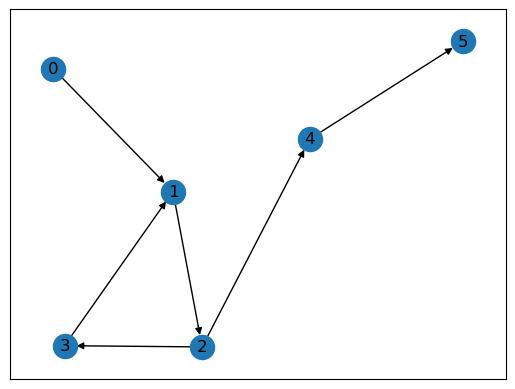

In [4]:
E = (E.detach().cpu().numpy().tolist() for E in edge_index.T)
G = nx.DiGraph(E)


nx.draw_networkx(G)

In [5]:
def get_degree(edge_index, idx): 
    src,dst = edge_index 
    
    out_degree = (src == idx).sum()
    in_degree = (dst == idx).sum()

    return in_degree, out_degree

In [6]:
def get_in_out_ixs(edge_index, idx): 
    '''
    Return the edge id (e.g., index of each edge in `edge_index` that corresponds to a given node `idx` inputs/outputs)
    '''
    src,dst = edge_index 
    
    in_ixs = (dst == idx).nonzero().view(-1)
    out_ixs= (src == idx).nonzero().view(-1)

    return in_ixs, out_ixs

In [7]:
def get_children(edge_index, idx): 
    src,dst = edge_index 
    return dst[src == idx]

In [8]:
class Node(torch.nn.Module): 
    def __init__(self, input_channels, output_channels, in_ixs, out_ixs, idx, children, attr_dim=0, hidden_channels=2, nonlin=torch.nn.ELU, dropout=0., bias=True): 
        super().__init__()

        self.in_ixs = in_ixs
        self.out_ixs = out_ixs
        self.idx = idx
        self.children = children

        self.nn = torch.nn.Sequential(torch.nn.Linear(input_channels + attr_dim, hidden_channels, bias=bias),
                                      torch.nn.BatchNorm1d(hidden_channels),
                                      nonlin(), 
                                      torch.nn.Dropout(dropout),
                                      torch.nn.Linear(hidden_channels, output_channels, bias=bias))
        
    def forward(self, x, attr=None): 


        x_in = x[:, self.in_ixs] # shape: (B, in_degree)

        if attr is not None: 
            x_in = torch.cat((x_in, attr[:, self.idx, :]), dim=-1) # shape: (B, in_degree + attr_dim)

        x_out = self.nn(x_in) # shape: (B, out_degree)

        # batch the indices
        B = x.size(0)
        indices = (torch.arange(B).unsqueeze(-1), self.out_ixs.unsqueeze(0).repeat(B, 1))

        x = torch.index_put(x, indices=indices, values=x_out)

        return x

In [9]:
class GSNN(torch.nn.Module): 
    def __init__(self, edge_index, input_mask, output_mask, hidden_channels, layers, attr_dim=0, dropout=0., nonlin=torch.nn.ELU): 
        super().__init__()

        self.edge_index = edge_index 
        self.input_mask = input_mask 
        self.output_mask = output_mask
        self.layers = layers

        self.node_dict = self.build_nodes(edge_index=edge_index, 
                                          input_mask=input_mask, 
                                          output_mask=output_mask, 
                                          hidden_channels=hidden_channels, 
                                          nonlin=nonlin,
                                          attr_dim=attr_dim, 
                                          dropout=dropout)
 
    def forward(self, x, attr=None): 
        
        # get children of "input" edges 
        src,dst = self.edge_index 
        function_evals = dst[self.input_mask]

        for l in range(self.layers): 
            function_evals_new = []
            for idx in function_evals: 
                x = self.node_dict[str(idx.item())](x, attr=attr)

                # get children 
                function_evals_new.append(self.node_dict[str(idx.item())].children)

            function_evals = torch.unique(torch.cat(function_evals_new, dim=-1))
            #remove "output" nodes from function evals (no "node" key); only for prediction output
            function_evals = function_evals[~torch.isin(function_evals, self.output_mask.nonzero())]

        return x


    def build_nodes(self, edge_index, input_mask, output_mask, hidden_channels, nonlin, dropout, attr_dim):
        
        # "function" nodes 
        # All nodes except the src in input edges and dst in output edges 
        src, dst = edge_index 
        function_node_ixs = torch.unique(torch.cat((src[~input_mask], dst[~output_mask]), dim=-1))

        node_dict = {}
        for i in function_node_ixs: 
            in_degree, out_degree = get_degree(edge_index, i)
            in_ixs, out_ixs = get_in_out_ixs(edge_index, i)
            children = get_children(edge_index, i)

            node = Node(input_channels=in_degree, 
                        output_channels=out_degree, 
                        in_ixs = in_ixs, 
                        out_ixs = out_ixs,
                        idx = i,
                        children = children, 
                        attr_dim = attr_dim,
                        hidden_channels=hidden_channels,
                        nonlin = nonlin,
                        dropout = dropout)
            
            node_dict[str(i.item())] = node
        
        return torch.nn.ModuleDict(node_dict)

In [10]:
model = GSNN(edge_index, input_mask, output_mask, hidden_channels=2, layers=6, attr_dim=attr.size(-1))

In [11]:
optim = torch.optim.Adam(model.parameters())

In [12]:
out = model(x0, attr=attr)
out.shape

torch.Size([2, 6])

In [13]:
out.squeeze()

tensor([[ 1.0000, -1.1449, -0.1961, -0.5899, -0.6036,  0.2013],
        [-1.0000, -0.2864, -0.3427, -0.1885, -0.5654,  0.2811]],
       grad_fn=<SqueezeBackward0>)

In [51]:
optim.zero_grad()
loss = (out**2).mean()
loss.backward()
optim.step()

In [272]:
src, dst = edge_index 
function_nodes = torch.unique(torch.cat((src[~input_mask], dst[~output_mask]), dim=-1))
function_nodes

tensor([1, 2, 3])